In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time
from googletrans import Translator


In [2]:
with open('data/final/sampled_references_pt.json','r',encoding='utf-8') as f:
    json_pt = json.load(f)
    df = pd.DataFrame(json_pt)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    return textdistance.levenshtein.normalized_similarity(norm_string(s1),norm_string(s2))

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(10)

,index,netloc
0,pt.wikipedia.org,97
1,viaf.org,45
2,divulgacandcontas.tse.jus.br,30
3,www.ebi.ac.uk,30
4,acervo.mp.usp.br,24
5,api.crossref.org,20
6,www.adorocinema.com,8
7,museus.cultura.gov.br,7
8,www.brasilianaiconografica.art.br,6
9,enciclopedia.itaucultural.org.br,6


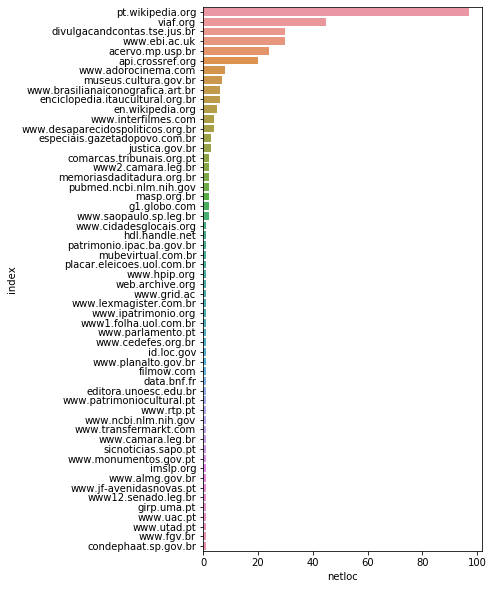

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## www.ebi.ac.uk
We see here that there are many types of predicates, but automating these many checks may be done.

Some here have the path for the api, some do not. We can only check those directed at the API, so we filter them. The ones filtered out are protein and gene databases which we'll check later.

### Article API

In [6]:
df_ebi = df[df['netloc'] == 'www.ebi.ac.uk']
df_ebi_api = df_ebi[df_ebi['path'] == '/europepmc/webservices/rest/search']
df_ebi_api['predicate'].value_counts(), df_ebi_api.shape[0]

(nome do autor           9
 instância de            5
 título                  4
 identificador PubMed    3
 número de jornal        3
 data de publicação      2
 página(s)               2
 publicado em            1
 DOI                     1
 Name: predicate, dtype: int64,
 30)

In [7]:
def verify_ebi_api(row, verbose=True):
#for i, row in df_en_ebi_api.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    d = requests.get(row['url']).json()['resultList']['result']
    
    if compare(subject, d[0]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d[0]['title'])
        #break
        return found
    if predicate == 'instância de':
        value = d[0]['pubTypeList']['pubType']
        if obj == 'artigo científico' \
            and 'Journal Article' in value \
            or 'Case Reports' in value \
            or 'Editorial' in value \
            or 'Letter' in value:
            found = True            
    elif predicate == 'data de publicação':
        value = d[0]['firstPublicationDate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'publicado em':
        obj = obj.replace('The BMJ','British medical journal')
        value = d[0]['journalInfo']['journal']['title']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = d[0]['doi']
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'nome do autor' or predicate == 'autor':
        value = d[0]['authorList']['author']
        for author in value:
            #if 'fullName' in author:
            #    print('Full name:',author['fullName'])
            #if 'firstName' in author:
            #    print('First and last names:',author['firstName'] + ' ' + author['lastName'])
            #print(obj)
            if 'fullName' in author and compare(obj, author['fullName']) >= 0.99:
                found = True
            elif 'firstName' in author and compare(obj, author['firstName'] + ' ' + author['lastName']) >= 0.99:
                found = True
    elif predicate == 'volume':
        value = d[0]['journalInfo']['volume']
        if value == obj:
            found = True
    elif predicate == 'página(s)':
        value = d[0]['pageInfo']
        if value == obj:
            found = True
    elif predicate == 'número de jornal':
        value = d[0]['journalInfo']['issue']
        if value == obj:
            found = True
    elif predicate == 'identificador PubMed':
        value = d[0]['id']
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'título':
        value = d[0]['title']
        if compare(obj, d[0]['title']) >= 0.9:
            found = True
    elif predicate == 'PMCID':
        value = d[0]['pmcid']
        if ('PMC'+obj) == value:
            found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ebi_api_verified = df_ebi_api.apply(verify_ebi_api,axis=1)
print('{}% are confirmed'.format(100*df_ebi_api_verified.sum()/len(df_ebi_api_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ebi_api.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_ebi_api[df_ebi_api_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### The rest of ebi.ac.uk (genes and proteins)

Conclusion: Names in subject / object differ too much from those obtained in the APIs, and there seems to be great need of domain knowledge (biology) to navigate through the information, making automatically checking the API daunting and approaches manual effort.

## pubmed.ncbi.nlm.nih.gov

These use a very similar json structure to ebi.ac.uk and the same endpoint as eutils so it is also possible to automatize

In [8]:
df_pubmed = df[df['netloc'] == 'pubmed.ncbi.nlm.nih.gov']
df_pubmed['predicate'].value_counts(), df_pubmed.shape

(nome do autor    2
 Name: predicate, dtype: int64,
 (2, 16))

In [9]:
def verify_pubmed(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    pubmed_id = row['url'].split('/')[-1]
    while 1:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pubmed_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d['result'][pubmed_id]['title'])
        #break
        return found
        
    if predicate == 'instância de':
        value = d['result'][pubmed_id]['pubtype']
        if obj == 'artículo científico' and 'Journal Article' in value:
            found = True            
    elif predicate == 'data de publicação':
        value = d['result'][pubmed_id]['sortpubdate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
        if 'epubdate' in d['result'][pubmed_id]:
            value = d['result'][pubmed_id]['epubdate']
            if parser.parse(obj).date() == parser.parse(value).date():
                found = True
    elif predicate == 'publicado em':
        value = d['result'][pubmed_id]['fulljournalname']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'doi'][0]
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'nome do autor' or predicate == 'autor':
        value = d['result'][pubmed_id]['authors']
        for author in value:
            if compare(obj, author['name']) >= 0.99:
                found = True
            else:
                authornames = re.split(' ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = ' '.join(authornames[1:]) + ' ' + authornames[0][1]
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[1::-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                    
                authornames = re.split('-| ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
    elif predicate == 'volume':
        value = d['result'][pubmed_id]['volume']
        if value == obj:
            found = True
    elif predicate == 'página(s)':
        value = d['result'][pubmed_id]['pages']
        values = value.split('-')
        if len(values[1]) < len(values[0]):
            valuedif = len(values[0]) - len(values[1])
            value = values[0] + '-' + values[0][0:valuedif] + values[1]
        if value == obj:
            found = True
    elif predicate == 'número de jornal':
        value = d['result'][pubmed_id]['issue']
        if value == obj:
            found = True
    elif predicate == 'identificador PubMed':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pubmed'][0]
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'título':
        value = d['result'][pubmed_id]['title']
        if compare(obj, value) >= 0.9:
            found = True
    #elif predicate == 'PMCID':
    #    value = d[0]['pmcid']
    #    if ('PMC'+obj) == value:
    #        found = True
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_pubmed_verified = df_pubmed.apply(verify_pubmed,axis=1)
print('{}% are confirmed'.format(100*df_pubmed_verified.sum()/len(df_pubmed_verified)))


# Mark them in the original df so that we don't crowdsource them
for i in df_pubmed.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_pubmed[df_pubmed_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


## api.crossref.org

simple api and not many predicates, automatable

In [10]:
df_crossref = df[df['netloc'] == 'api.crossref.org']
df_crossref['predicate'].value_counts()

cita    19
ISSN     1
Name: predicate, dtype: int64

In [11]:
import urllib.parse
cont_info = '?mailto=k2031554@kcl.ac.uk'

def verify_crossref(row, verbose=True):
#verbose = True
#for i, row in df_en_crossref.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    r = requests.get(row['url']+cont_info)
    #print(row['url'])
    d = r.json()
    
    item_title = d['message']['title']
    if type(item_title) is list:
        item_title = item_title[0]
    if compare(subject, item_title) < 0.9:
        translator = Translator()
        translated_title = translator.translate(item_title, dest='en').text
        if compare(subject, translated_title) <0.6:
            if verbose:
                print(subject)
                print(item_title)
                print(translated_title)
            #break
            return found
        
    if predicate == 'instância de':
        value = d['message']['type']
        if obj == 'scholarly article' and 'journal-article' in value:
            found = True 
    elif predicate == 'cita':
        if 'reference' in d['message']:
            value = d['message']['reference']
        else:
            value = []
        for ref in value:
            try:
                if 'article-title' in ref:
                    title = ref['article-title']
                elif 'DOI' in ref:
                    doi = urllib.parse.quote_plus(ref['DOI'])
                    resp = requests.get('https://api.crossref.org/works/'+doi+cont_info)
                    if resp.status_code != 404:
                        if len(resp.json()['message']['title']) > 0:
                            title = resp.json()['message']['title'][0]
                        elif len(resp.json()['message']['container-title']) >0:
                            title = resp.json()['message']['container-title'][0]
                        else:
                            title = ''
                    else:
                        title = ''
                    #print(title)
                elif 'unstructured' in ref:
                    title = ref['unstructured'].split('In:')[0]
                    #print(title)
                
                elif 'volume-title' in ref:
                    title = ref['volume-title']
                elif 'series-title' in ref:
                    title = ref['series-title']
                elif 'journal-title' in ref:
                    title = ref['journal-title']
                #print('Object is:',obj)
                #print('Title is:',title)
                if compare(obj,title) >= 0.9:
                    found = True
                    break
                else:
                    translator = Translator()
                    translated_title = translator.translate(title, dest='en').text
                    #print('Translation is:',translated_title)
                    #print('Similarity is:', compare(obj, translated_title))
                    #print('\n')
                    if compare(obj, translated_title) >= 0.7:
                        found = True
                        break
            except Exception as e:
                print(row['url'])
                print(e)
                print(resp.__dict__)
                print('\n')
    if not found and verbose:
        print(predicate)
        print(obj)
        #print(value)
        #break
    return found

df_crossref_verified = df_crossref.apply(verify_crossref,axis=1)
print('{}% are confirmed'.format(100*df_crossref_verified.sum()/len(df_crossref_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_crossref.index:
    df.loc[i,'verified'] = True

# Those not verified
df_crossref[df_crossref_verified == False]

Cutaneous and pulmonary paracoccidioidomycosis in a patient with a malignant visceral tumor.
Paracoccidioidomicose cutânea disseminada e pulmonar em paciente portador de neoplasia maligna visceral
Paracoccidioidomycosis disseminated skin and lung in a patient visceral malignancy
Sociologia
Sociologia Problemas e Práticas
Sociology Problems and Practices
English Language Teaching: phonetics, phonology and auditory processing contributions.
Ensino da Língua Inglesa: contribuições da fonética, fonologia e do processamento auditivo
Teaching English Language: phonetic contributions, phonology and auditory processing
85.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
39,d54ffdea03e701e30fe701dbfc6f4cc8965bdb68,https://api.crossref.org/works/10.1590%2FS0365...,{'stated in': 'wikibase-item:>Crossref->Q51882...,pt,Q40298197-9A85567D-0F9F-4189-9D20-F688B23472AE,Cutaneous and pulmonary paracoccidioidomycosis...,cita,Paracoccidioidomycosis and AIDS: an overview.,0,False,https,api.crossref.org,/works/10.1590%2FS0365-05962011000600029,,,
55,d73801b4ec20b6d64594bcc7c1e3ad08acd1366b,https://api.crossref.org/journals/2182-7907,"{'retrieved': 'time:>+2018-03-23T00:00:00Z', '...",pt,Q50497622-543CFBA9-5EC3-4EC0-B2B2-904D5475CAC8,Sociologia,ISSN,2182-7907,0,False,https,api.crossref.org,/journals/2182-7907,,,
303,0d4427396ea865f637bfc214509e61b4b0b3d262,https://api.crossref.org/works/10.1590%2FS0104...,{'stated in': 'wikibase-item:>Crossref->Q51882...,pt,Q43556574-8A32067F-3ED9-4C30-B472-29C9B1291D0D,"English Language Teaching: phonetics, phonolog...",cita,Plasticity of illusory vowel perception in Bra...,0,False,https,api.crossref.org,/works/10.1590%2FS0104-56872010000300005,,,


### Some cases above could not be checked because the translations from google and the translations used in Wikidata differ too much. In these cases, we had to analyse by hand (3 cases) and check. We verified them all, so the confirmed rate is actually 100%.

## viaf.org

In [12]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

identificador WorldCat Identities                25
identificador PTBNP                               8
identificador SUDOC                               2
identificador NTA PPN                             2
identificador GND                                 2
identificador BnF                                 2
data de nascimento                                1
número de controlo da Biblioteca do Congresso     1
ISNI                                              1
identificador na VIAF                             1
Name: predicate, dtype: int64

In [13]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    try:
        if type(d['mainHeadings']['data']) is not list:
            d['mainHeadings']['data']= [d['mainHeadings']['data']]
        names = [name['text'] for name in d['mainHeadings']['data']]
        for to_add in ['mainHeadings/mainHeadingEl','x400s/x400','x500s/x500']:
            to_add = to_add.split('/')
            if to_add[0] in d:
                if type(d[to_add[0]][to_add[1]]) != list:
                    d[to_add[0]][to_add[1]] = [d[to_add[0]][to_add[1]]]
                names_i = [i['datafield']['subfield'] for i in d[to_add[0]][to_add[1]]]
                names_i = [n if type(n) == list else [n] for n in names_i]
                names_i = [item['#text'] for sublist in names_i for item in sublist]
                names += names_i
    except Exception:
        print(url)
        print(d)
        raise

    if all([compare(subject,name) < 0.9 for name in names]):
        if verbose:
            print(url)
            print(subject)
            print(names)
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'identificador BnF':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj.startswith(value):
            found = True
    elif predicate == 'identificador WorldCat Identities':
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    elif predicate == 'identificador BAV':
        value = [i for i in flat_ids if i.startswith('BAV|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador NTA PPN':
        value = [i for i in flat_ids if i.startswith('NTA|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador NKC':
        value = [i for i in flat_ids if i.startswith('NKC|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador SUDOC':
        value = [i for i in flat_ids if i.startswith('SUDOC|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador GND':
        value = [i for i in flat_ids if i.startswith('DNB|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador PTBNP':
        value = [i for i in flat_ids if i.startswith('PTBNP|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador na VIAF':
        if obj in [viaf_id]:
            found = True
    elif predicate == 'número de controlo da Biblioteca do Congresso':
        value = [i for i in flat_ids if i.startswith('LC|')][0].split('|')[-1].replace(' ','')
        if obj in [value]:
            found = True
    elif predicate == 'data de nascimento':
        value = d['birthDate']
        if obj.startswith(value):
            found = True
    elif predicate == 'ISNI':
        value = [i for i in flat_ids if i.startswith('ISNI|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    else:
        print(flat_ids)
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf.index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

http://www.viaf.org/viaf/48292325/viaf.json
Jorge Listopad
['Listopad, Jorge, 1921-2017', 'Listopad, Jorge', 'Listopad, Jorge', 'Listopad, Jorge', 'Listopad, Jorge', 'Listopad, Jorge,', '1921-2017', 'Listopad,', 'Jorge,', '1921-2017', 'Listopad, Georges F.', 'Listopad, Jorge', 'Listopad,', 'Jorge']
http://www.viaf.org/viaf/136608254/viaf.json
Oikos
['Oikos centro studi', 'Oikos centro studi', "Centro internazionale di studio ricerca e documentazione dell'abitare", 'Centro studi Oikos', "Centro studi dell'abitare", "Centro studi dell'abitare Oikos"]
95.55555555555556% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
4,2dd5a2f966dd318efe0818bc63a26f681bd475fc,https://viaf.org/viaf/48292325,{'VIAF ID': 'value:>48292325'},pt,Q712082-BCFA0674-1112-4F76-879F-CDF53454BDD9,Jorge Listopad,identificador WorldCat Identities,lccn-n87870435,0,False,https,viaf.org,/viaf/48292325,,,
210,4d2f809c3315159b81424f8a6a199089e6bbf865,https://viaf.org/viaf/136608254,{'VIAF ID': 'value:>136608254'},pt,Q63253138-DA2EAE8B-37B4-4967-9D73-C9C2B313CA5B,Oikos,identificador WorldCat Identities,viaf-136608254,0,False,https,viaf.org,/viaf/136608254,,,


### Some cases above could not be checked because the translations from google and the translations used in Wikidata differ too much. In these cases, we had to analyse by hand (1 case) and check. We verified them all, so the confirmed rate is actually 100%.

# Final: filter reference list for tasks and create file with checked references

In [15]:
df[df['verified'] == False]['netloc'].value_counts()

pt.wikipedia.org                     97
divulgacandcontas.tse.jus.br         30
acervo.mp.usp.br                     24
www.adorocinema.com                   8
museus.cultura.gov.br                 7
www.brasilianaiconografica.art.br     6
enciclopedia.itaucultural.org.br      6
en.wikipedia.org                      5
www.desaparecidospoliticos.org.br     4
www.interfilmes.com                   4
especiais.gazetadopovo.com.br         3
justica.gov.br                        3
g1.globo.com                          2
memoriasdaditadura.org.br             2
www.saopaulo.sp.leg.br                2
www2.camara.leg.br                    2
comarcas.tribunais.org.pt             2
masp.org.br                           2
www1.folha.uol.com.br                 1
www.ipatrimonio.org                   1
www.cedefes.org.br                    1
www.parlamento.pt                     1
web.archive.org                       1
www.hpip.org                          1
patrimonio.ipac.ba.gov.br             1


In [14]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_pt if j['reference_id'] in not_verified_reference_ids]
with open('data/final/filtered_sampled_references_pt_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 243. That is 71.47058823529412% left from the total.


In [ ]:
def is_wikipedia(url):
    if url.startswith('https://pt.wikipedia.org'):
        return True
    elif url.startswith('https://en.wikipedia.org'):
        return True
    return False

not_verified_references_non_wikipedia = [r for r in not_verified_references if not is_wikipedia(r['url'])]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_pt_auth.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references_non_wikipedia,f ,indent=2,ensure_ascii=False)

In [16]:
df[df['verified'] == True]['netloc'].value_counts()

viaf.org                   45
www.ebi.ac.uk              30
api.crossref.org           20
pubmed.ncbi.nlm.nih.gov     2
Name: netloc, dtype: int64

In [17]:
verified_reference_ids = list(df[df['verified'] == True]['reference_id'])
print('Number of verified references: {}. That is {}% from the total.'.format(
    len(verified_reference_ids), 100*len(verified_reference_ids)/df.shape[0]
))

Number of verified references: 97. That is 28.529411764705884% from the total.


In [18]:
verified_references = [j for j in json_pt if j['reference_id'] in verified_reference_ids]
for vr in verified_references:
    vr['g_id'] = {
      "relevance": {
          "is_present": 1,
          "difficulty": -1,
          "reason": -1
      },
      "authorit":{
          "author": -1,
          "publisher": -1,
          "sub_publisher": -1
      }
    }
    
    if 'www.ebi.ac.uk/europepmc/webservices/rest/search' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'pubmed.ncbi.nlm.nih.gov' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'api.crossref.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 1
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 2
    elif 'viaf.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 2
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 1
        vr['g_id']['authorit']['sub_publisher'] = 3

with open('data/final/non_gd_annotations_auto_api/autochecked_sampled_references_pt.json','w',encoding='utf-8') as f:
    json.dump(verified_references,f ,indent=2,ensure_ascii=False)

### Then, go to the autochecked results file saved on the previous cell and edit the cases where verification failed